# Analyse dataset Peyser (GSE129605)

In [2]:
import scanpy as sc
import os
import gzip
import shutil
from tqdm.notebook import tqdm
import anndata
import matplotlib.pyplot as plt
import helpers_danielstrobel
from IPython.display import Image
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation
import anndata2ri
import logging
import scrublet
import pandas as pd
import utils


import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro


rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
plt.rcParams['figure.figsize'] = (9, 9)

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead o

## Load and Merge raw data

In [5]:
path = "GSE129605"

In [6]:
adata_raw = {}
for folder in tqdm(os.listdir(path)):
    adata_raw[folder] = sc.read_10x_mtx(os.path.join(path, folder))

  0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
adata_raw = anndata.concat(adata_raw, label="samples")

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
adata_raw.obs[['GSM', 'tmp']] = adata_raw.obs['samples'].str.split("_", expand = True)
adata_raw.obs[['condition', 'id']] = adata_raw.obs['tmp'].str.split(".", expand = True)
adata_raw.obs.drop(columns=['tmp'], inplace=True)
adata_raw.obs

samples         GSM   condition   
AAACCTGAGGAATTAC-1      GSM3716976_saline.947170  GSM3716976      saline  \
AAACCTGCATAACCTG-1      GSM3716976_saline.947170  GSM3716976      saline   
AAACCTGCATTGGGCC-1      GSM3716976_saline.947170  GSM3716976      saline   
AAACCTGGTCTCAACA-1      GSM3716976_saline.947170  GSM3716976      saline   
AAACCTGGTTGACGTT-1      GSM3716976_saline.947170  GSM3716976      saline   
...                                          ...         ...         ...   
TTTGCGCCAGACAAGC-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGCGCGTCATATGC-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGCGCGTCCGAATT-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGGTTGTAGCTTGT-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGGTTTCATCGATG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   

                        id  
AAACCTGAGGAATTAC-1  947170  
AAACCTGCATAACCTG-1  947170  
AAACCTGCATTGGGCC-1  947170  
AAACCTGGTCTCAACA-1  947170  
AAACCTGGTTGACGTT-1  947170  
...                    ...  
TTTGCGCCAGACAAGC-1  947178  
TTTGCGCGTCATATGC-1  947178  
TTTGCGCGTCCGAATT-1  947178  
TTTGGTTGTAGCTTGT-1  947178  
TTTGGTTTCATCGATG-1  947178  

[18975 rows x 4 columns]

### Quality Control

In [9]:
adata_raw.var_names_make_unique()
adata_raw.obs_names_make_unique()
adata_raw

AnnData object with n_obs × n_vars = 18975 × 25127
    obs: 'samples', 'GSM', 'condition', 'id'

In [10]:
# mitochondrial genes
adata_raw.var["mt"] = adata_raw.var_names.str.startswith("MT-", "mt-")
# ribosomal genes
adata_raw.var["ribo"] = adata_raw.var_names.str.startswith(("RPS", "RPL", "rps", "rpl"))
# hemoglobin genes.
adata_raw.var["hb"] = adata_raw.var_names.str.contains(("^HB[^(P)]|^hb[^(p)]"))

In [11]:
sc.pp.calculate_qc_metrics(
    adata_raw, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata_raw

AnnData object with n_obs × n_vars = 18975 × 25127
    obs: 'samples', 'GSM', 'condition', 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

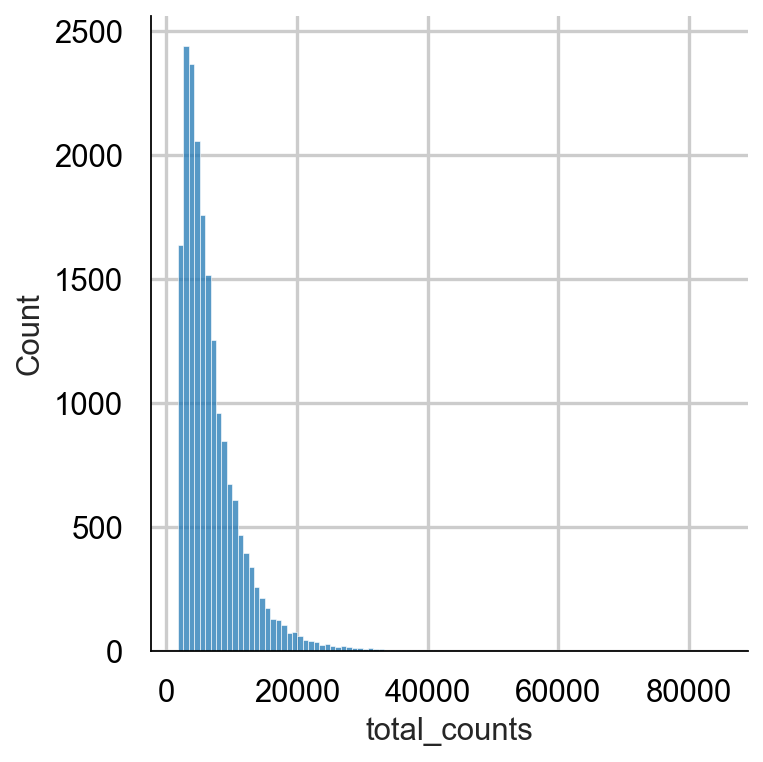

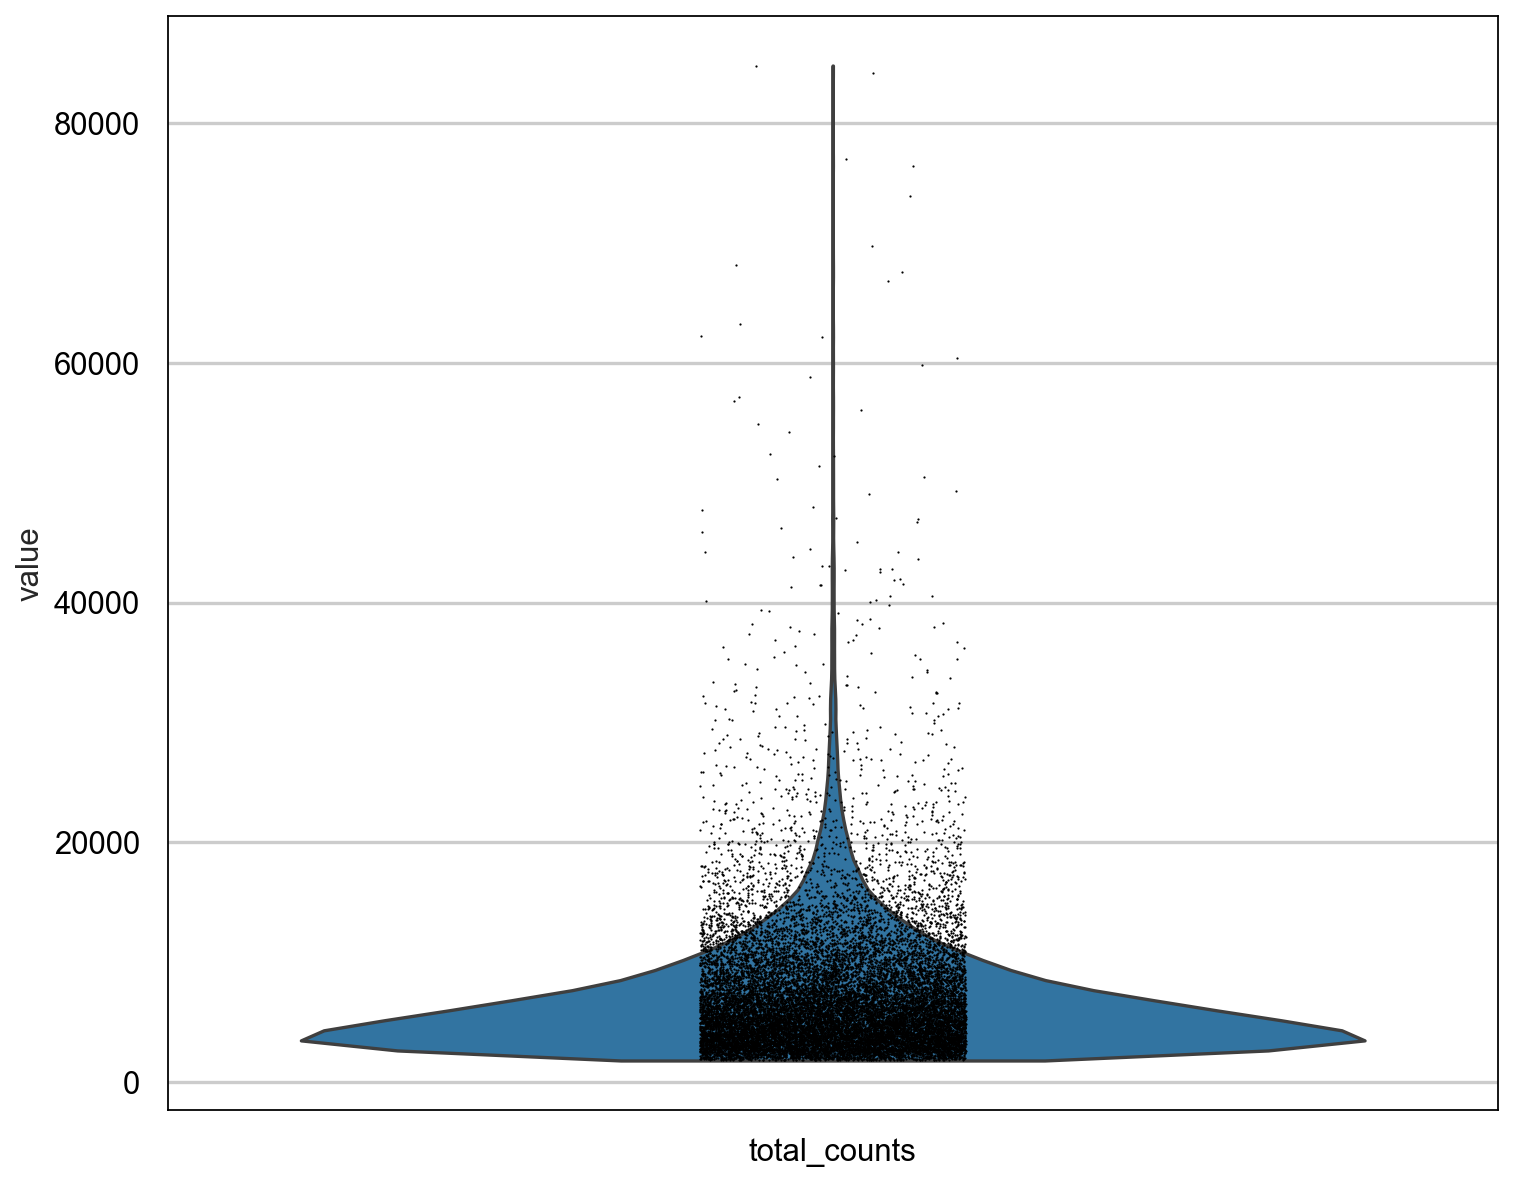

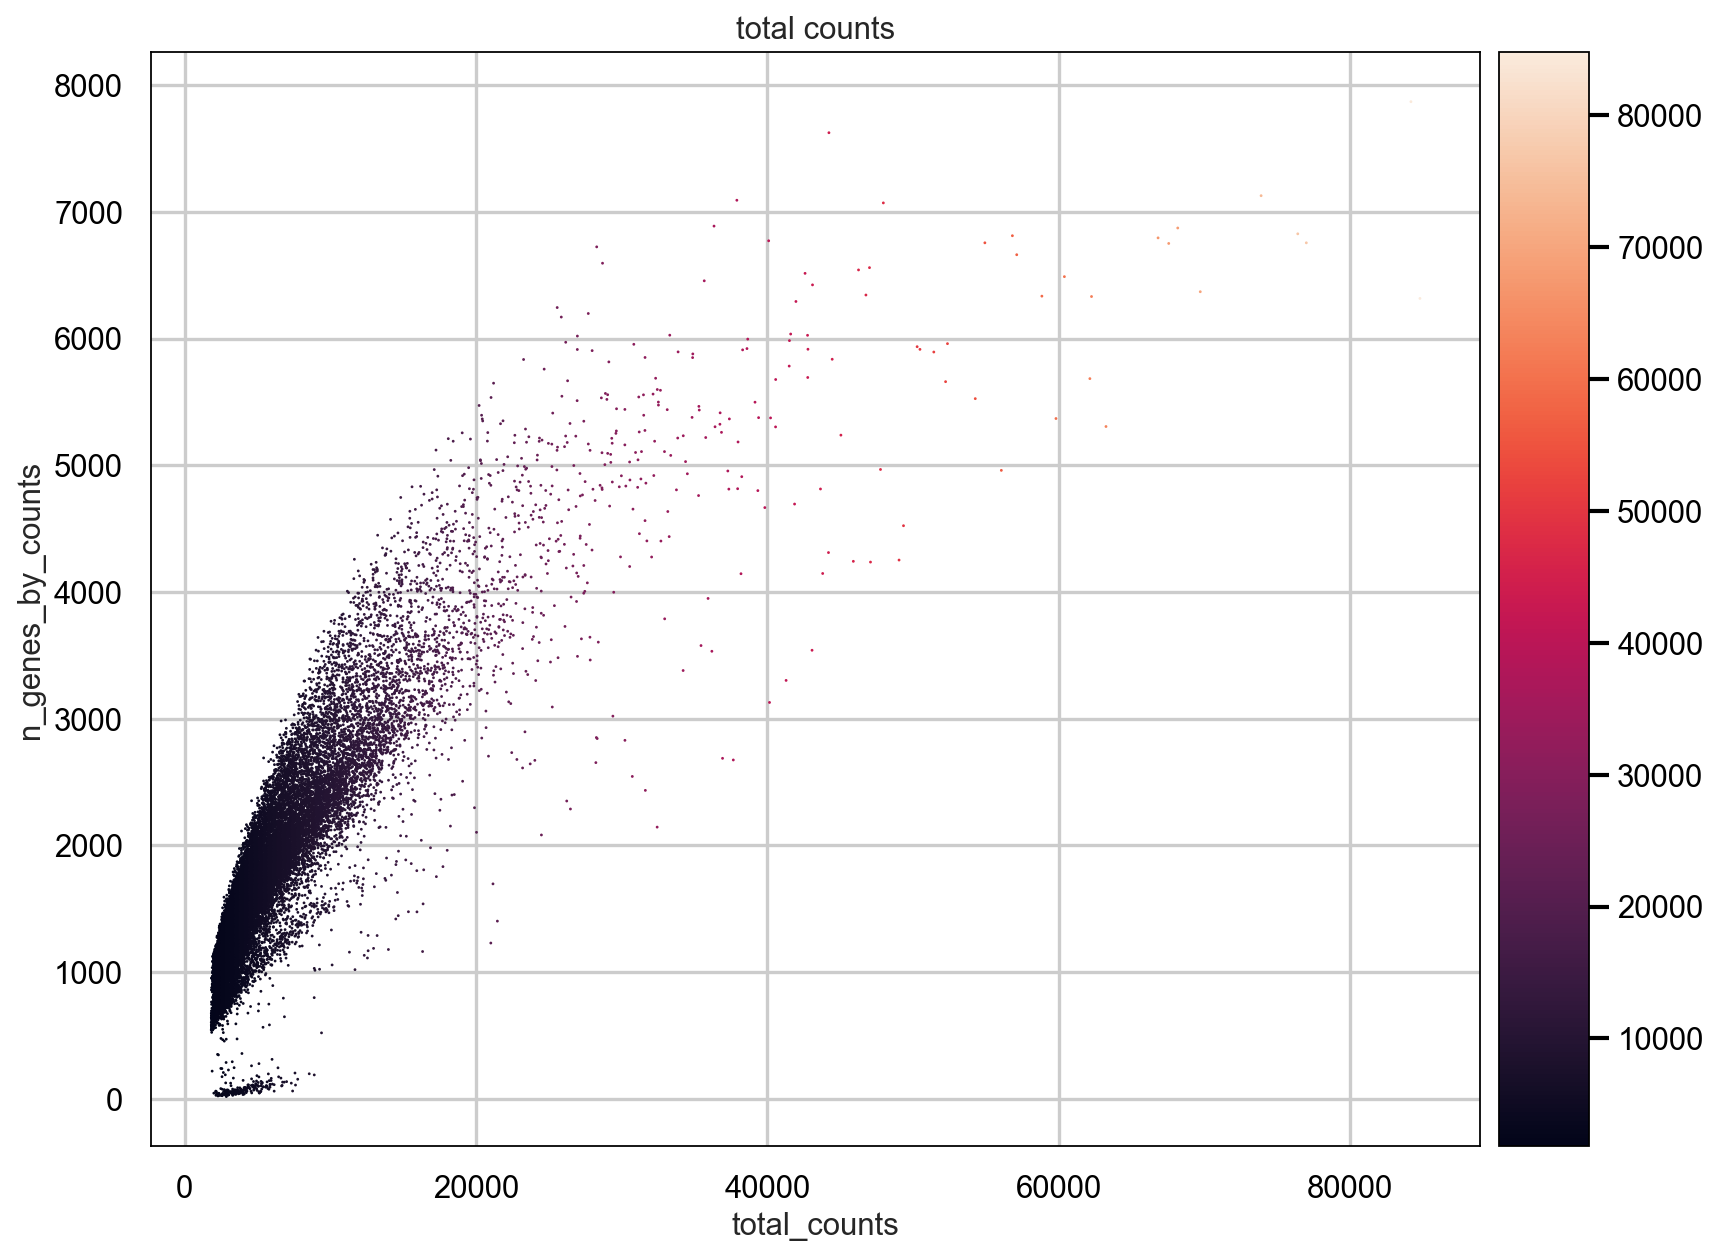

In [12]:
p1 = sns.displot(adata_raw.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata_raw, 'total_counts')
#p2 = sc.pl.violin(adata_raw, "pct_counts_mt")
p3 = sc.pl.scatter(adata_raw, "total_counts", "n_genes_by_counts", color="total_counts")

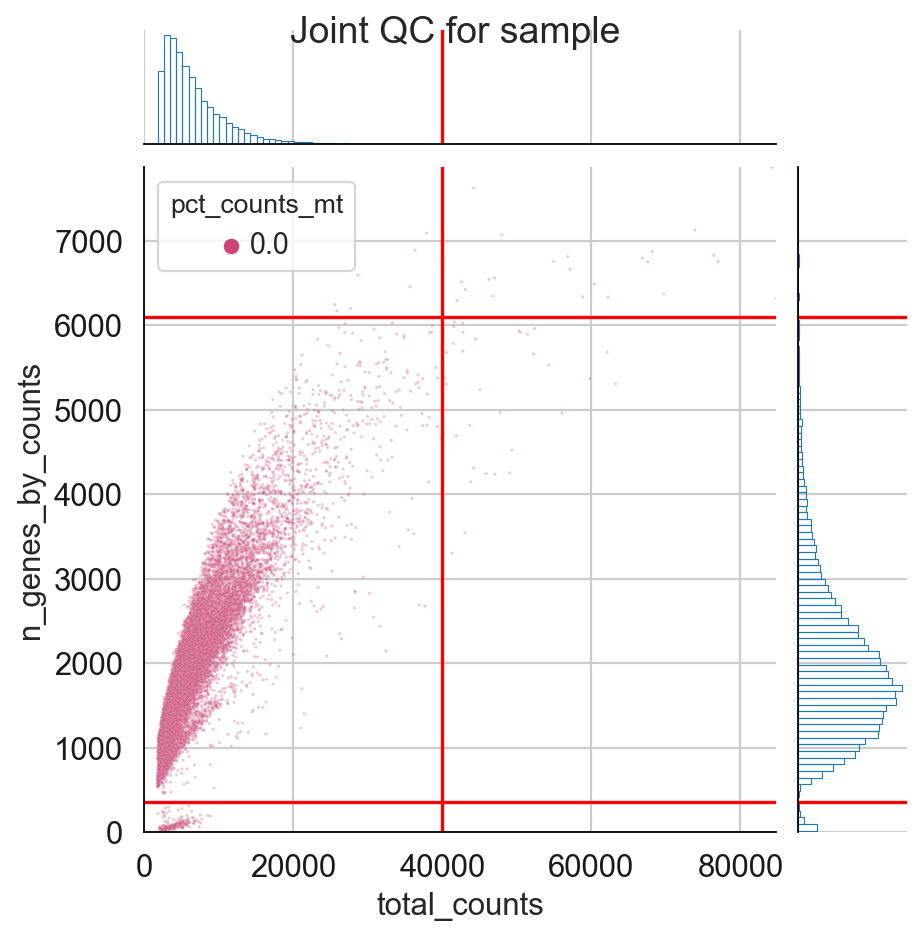

In [16]:
utils.plot_qc_joint(adata_raw, x="total_counts",
                    y='n_genes_by_counts',
                    hue='pct_counts_mt',
                    palette='plasma',
                    x_threshold=(350, 6100),   # total_counts
                    y_threshold=(0, 40000),    # n_genes_by_counts
                    title='Joint QC for sample ')


In [17]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [18]:
adata_raw.obs["outlier"] = (
    is_outlier(adata_raw, "log1p_total_counts", 5)
    | is_outlier(adata_raw, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_raw, "pct_counts_in_top_20_genes", 5)
)
adata_raw.obs.outlier.value_counts()

outlier
False    17556
True      1419
Name: count, dtype: int64

In [19]:
adata_raw.obs["mt_outlier"] = is_outlier(adata_raw, "pct_counts_mt", 3) | (
    adata_raw.obs["pct_counts_mt"] > 8
)
adata_raw.obs.mt_outlier.value_counts()

mt_outlier
False    18975
Name: count, dtype: int64

In [20]:
print(f"Total number of cells: {adata_raw.n_obs}")
adata_raw = adata_raw[(~adata_raw.obs.outlier) & (~adata_raw.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata_raw.n_obs}")

Total number of cells: 18975
Number of cells after filtering of low quality cells: 17556


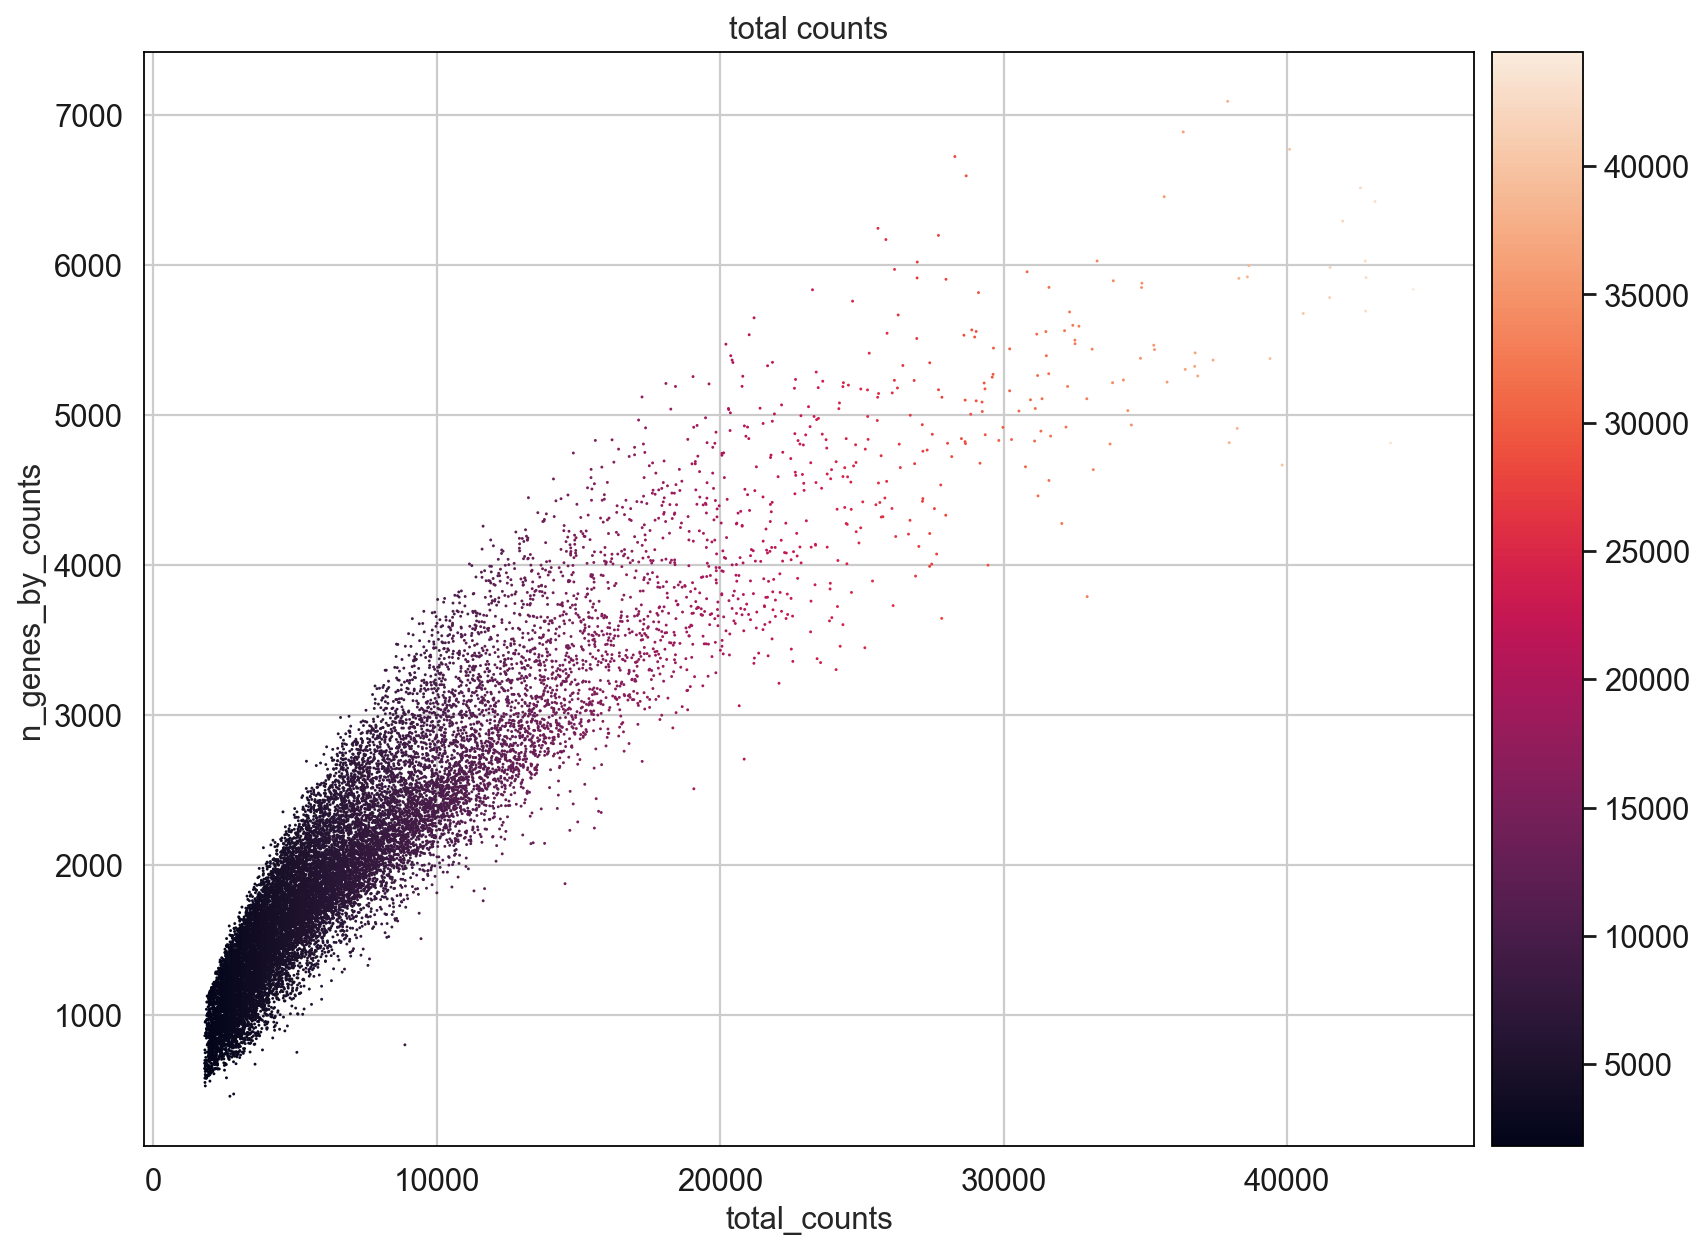

In [21]:
p1 = sc.pl.scatter(adata_raw, "total_counts", "n_genes_by_counts", color="total_counts")

### Normalization

In [22]:
scales_counts = sc.pp.normalize_total(adata_raw, target_sum=None, inplace=False)
# log1p transform
adata_raw.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata_raw.X = adata_raw.layers['log1p_norm']

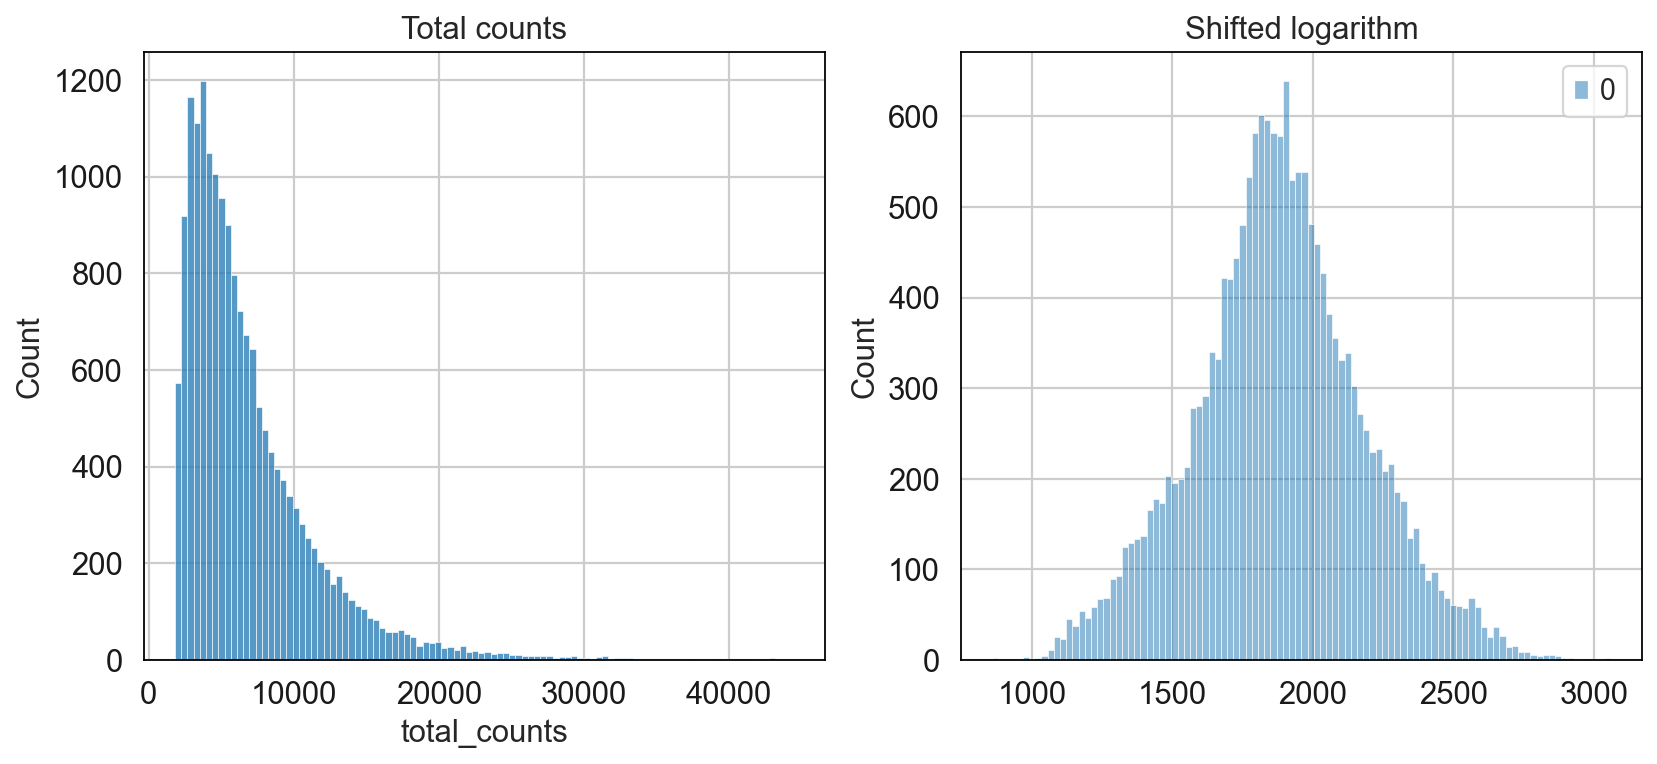

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
p1 = sns.histplot(adata_raw.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata_raw.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### Feature Selection

In [24]:
print("Number of genes in data before filtering: ", adata_raw.n_vars)
print("Number of cells in data before filtering: ", adata_raw.n_obs)

sc.pp.filter_cells(adata_raw, min_genes=350)
sc.pp.filter_cells(adata_raw, max_genes=6100)
sc.pp.filter_cells(adata_raw, max_counts=40000)
sc.pp.filter_genes(adata_raw, min_counts=1)

print("Number of genes in filtered data: ", adata_raw.n_vars)
print("Number of cells in filtered data: ", adata_raw.n_obs)

Number of genes in data before filtering:  25127
Number of cells in data before filtering:  17556
Number of genes in filtered data:  18252
Number of cells in filtered data:  17544


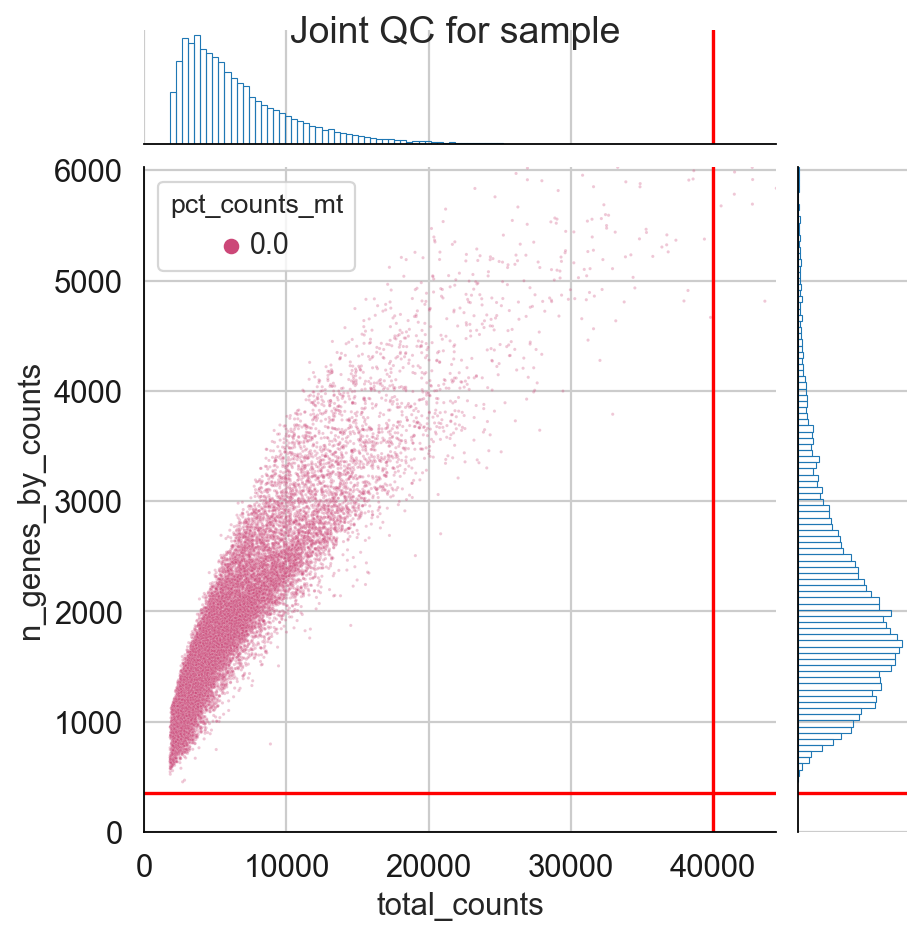

In [25]:
# plot after selection
utils.plot_qc_joint(adata_raw, x="total_counts",
                    y='n_genes_by_counts',
                    hue='pct_counts_mt',
                    palette='plasma',
                    x_threshold=(350, 6100),  # total_counts
                    y_threshold=(0, 40000),  # n_genes_by_counts
                    title='Joint QC for sample ')

In [26]:
adata_raw.write("data/adata_processed_lea.h5ad")

In [3]:
adata = sc.read("data/adata_processed_lea.h5ad")

### Dimensionality Reduction

In [4]:
sc.pp.pca(adata)
# Berechnen der Nachbarschaften
sc.pp.neighbors(adata)
# Reduzieren der Dimensionen mit UMAP
sc.tl.umap(adata)

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


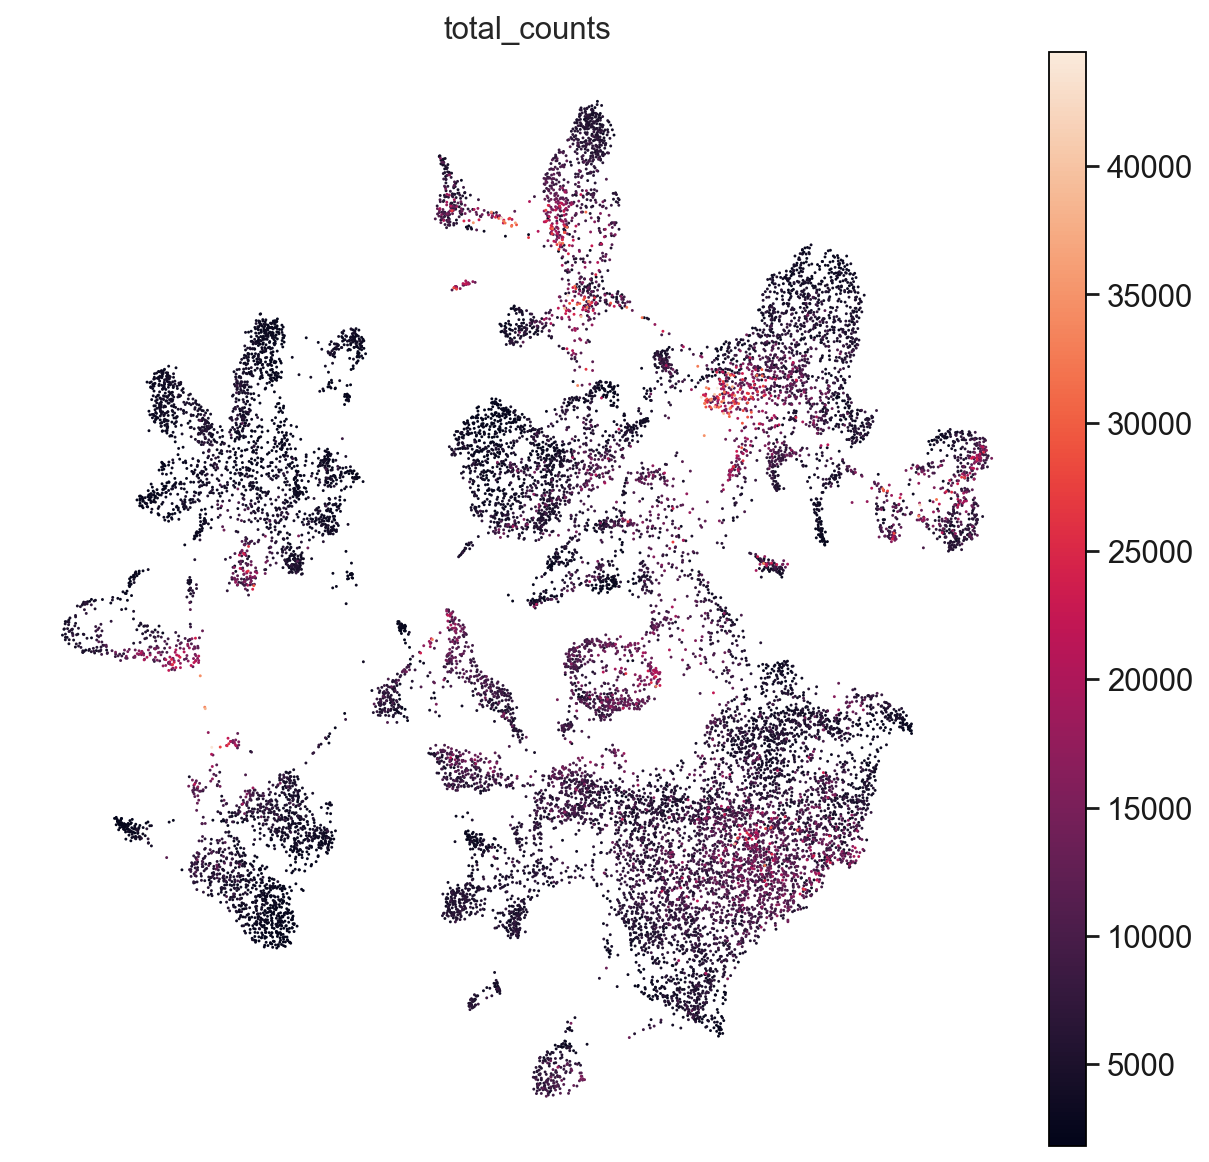

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


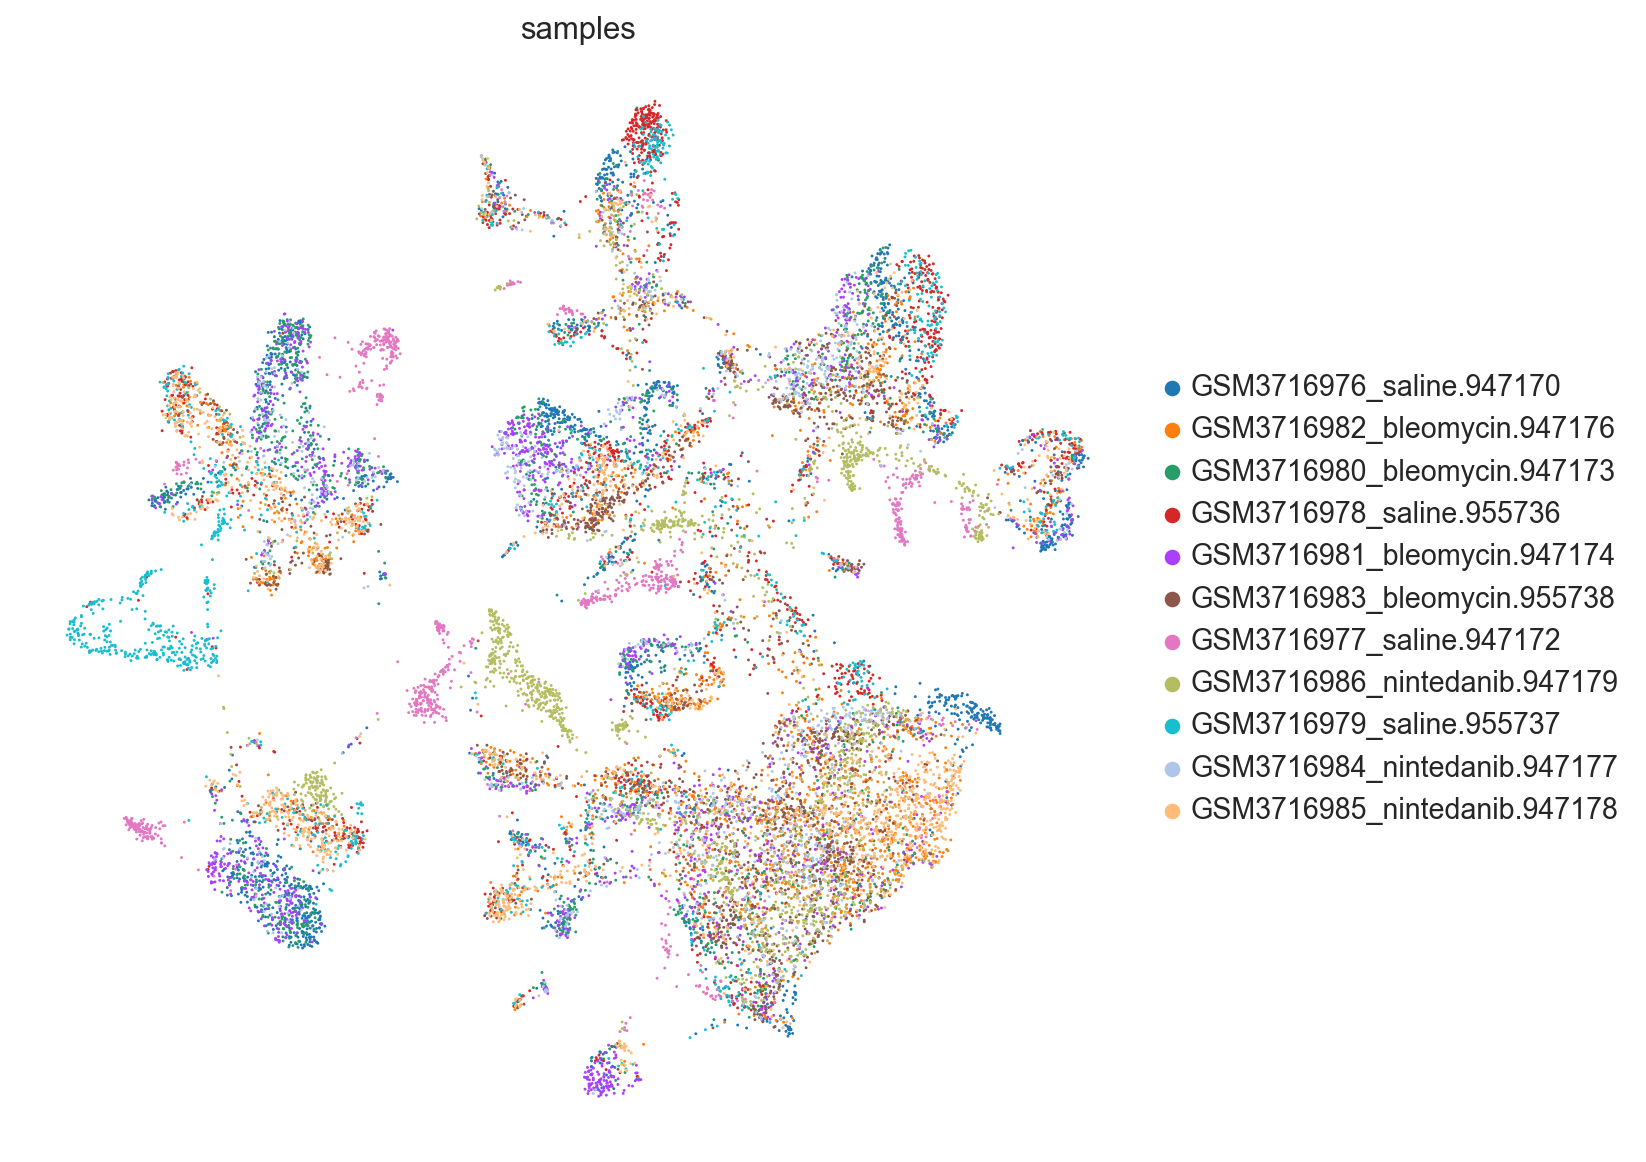

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


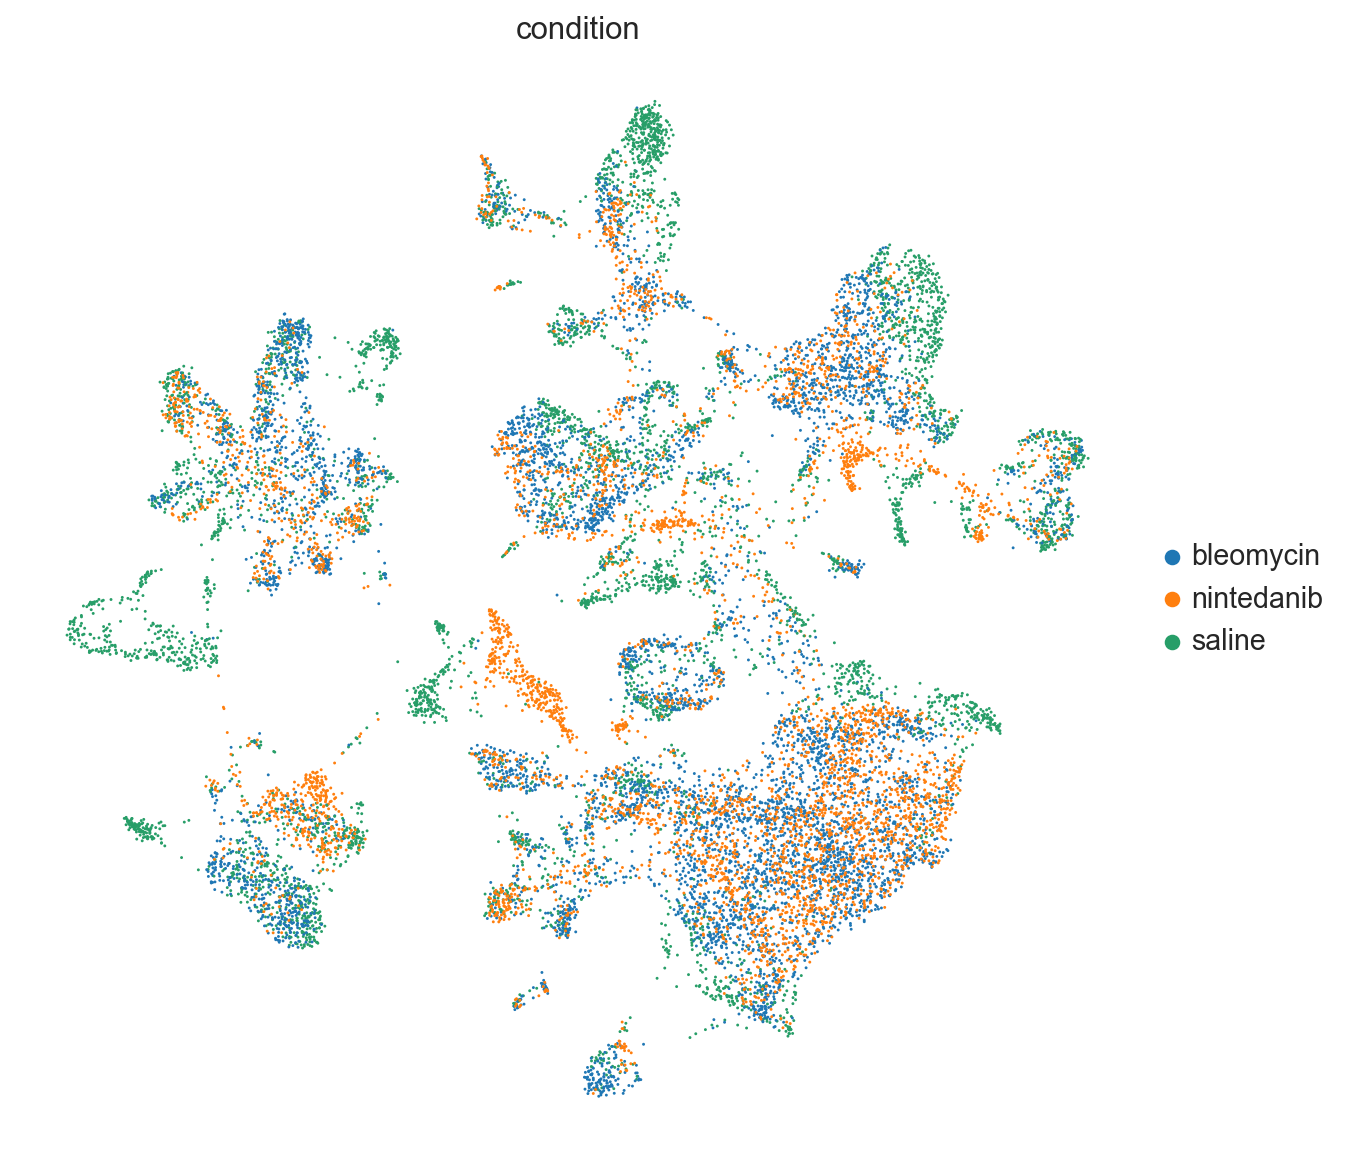

In [5]:
sc.pl.umap(adata=adata, color=["total_counts"])
sc.pl.umap(adata=adata, color=["samples"])
sc.pl.umap(adata=adata, color=["condition"])

### Doublet-Detektion

In [6]:
# Führe die Doublet-Detektion durch
# Hier verwenden wir die Funktion `sc.tl.scrub()` von scanpy
sc.external.pp.scrublet(adata)

# Erhalte die Doublet-Wahrscheinlichkeiten
doublet_scores = adata.obs['predicted_doublet']

# Bestimme einen Schwellenwert, um Doublets zu identifizieren
threshold = 0.5

# Markiere Doublets basierend auf dem Schwellenwert
adata.obs['is_doublet'] = doublet_scores > threshold

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 71.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.4%


In [7]:
adata.obs['is_doublet'] = adata.obs['is_doublet'].astype(str)
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype(str)
adata.obs

samples         GSM   condition   
AAACCTGAGGAATTAC-1      GSM3716976_saline.947170  GSM3716976      saline  \
AAACCTGCATAACCTG-1      GSM3716976_saline.947170  GSM3716976      saline   
AAACCTGCATTGGGCC-1      GSM3716976_saline.947170  GSM3716976      saline   
AAACCTGGTCTCAACA-1      GSM3716976_saline.947170  GSM3716976      saline   
AAACCTGGTTGACGTT-1      GSM3716976_saline.947170  GSM3716976      saline   
...                                          ...         ...         ...   
TTTGCGCCAGACAAGC-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGCGCGTCATATGC-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGCGCGTCCGAATT-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGGTTGTAGCTTGT-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   
TTTGGTTTCATCGATG-1  GSM3716985_nintedanib.947178  GSM3716985  nintedanib   

                        id  n_genes_by_counts  log1p_n_genes_by_counts   
AAACCTGAGGAATTAC-1  947170               1158                 7.055313  \
AAACCTGCATAACCTG-1  947170               1526                 7.331060   
AAACCTGCATTGGGCC-1  947170               2115                 7.657283   
AAACCTGGTCTCAACA-1  947170               2395                 7.781556   
AAACCTGGTTGACGTT-1  947170               1154                 7.051856   
...                    ...                ...                      ...   
TTTGCGCCAGACAAGC-1  947178               2766                 7.925519   
TTTGCGCGTCATATGC-1  947178               1273                 7.149917   
TTTGCGCGTCCGAATT-1  947178               1472                 7.295056   
TTTGGTTGTAGCTTGT-1  947178               1673                 7.422971   
TTTGGTTTCATCGATG-1  947178               1381                 7.231287   

                    total_counts  log1p_total_counts   
AAACCTGAGGAATTAC-1        2729.0            7.912057  \
AAACCTGCATAACCTG-1        6030.0            8.704668   
AAACCTGCATTGGGCC-1        5689.0            8.646465   
AAACCTGGTCTCAACA-1        8031.0            8.991189   
AAACCTGGTTGACGTT-1        2060.0            7.630947   
...                          ...                 ...   
TTTGCGCCAGACAAGC-1       13438.0            9.505917   
TTTGCGCGTCATATGC-1        3268.0            8.092239   
TTTGCGCGTCCGAATT-1        4342.0            8.376321   
TTTGGTTGTAGCTTGT-1        5851.0            8.674539   
TTTGGTTTCATCGATG-1        3371.0            8.123261   

                    pct_counts_in_top_20_genes  total_counts_mt  ...   
AAACCTGAGGAATTAC-1                   22.792232              0.0  ...  \
AAACCTGCATAACCTG-1                   23.598673              0.0  ...   
AAACCTGCATTGGGCC-1                   19.968360              0.0  ...   
AAACCTGGTCTCAACA-1                   28.066243              0.0  ...   
AAACCTGGTTGACGTT-1                   18.203883              0.0  ...   
...                                        ...              ...  ...   
TTTGCGCCAGACAAGC-1                   35.280548              0.0  ...   
TTTGCGCGTCATATGC-1                   30.293758              0.0  ...   
TTTGCGCGTCCGAATT-1                   19.345924              0.0  ...   
TTTGGTTGTAGCTTGT-1                   20.133311              0.0  ...   
TTTGGTTTCATCGATG-1                   18.540492              0.0  ...   

                    total_counts_hb  log1p_total_counts_hb  pct_counts_hb   
AAACCTGAGGAATTAC-1              0.0                    0.0            0.0  \
AAACCTGCATAACCTG-1              0.0                    0.0            0.0   
AAACCTGCATTGGGCC-1              0.0                    0.0            0.0   
AAACCTGGTCTCAACA-1              0.0                    0.0            0.0   
AAACCTGGTTGACGTT-1              0.0                    0.0            0.0   
...                             ...                    ...            ...   
TTTGCGCCAGACAAGC-1              0.0                    0.0            0.0   
TTTGCGCGTCATATGC-1              0.0                    0.0            0.0   
TTTGCGCG

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


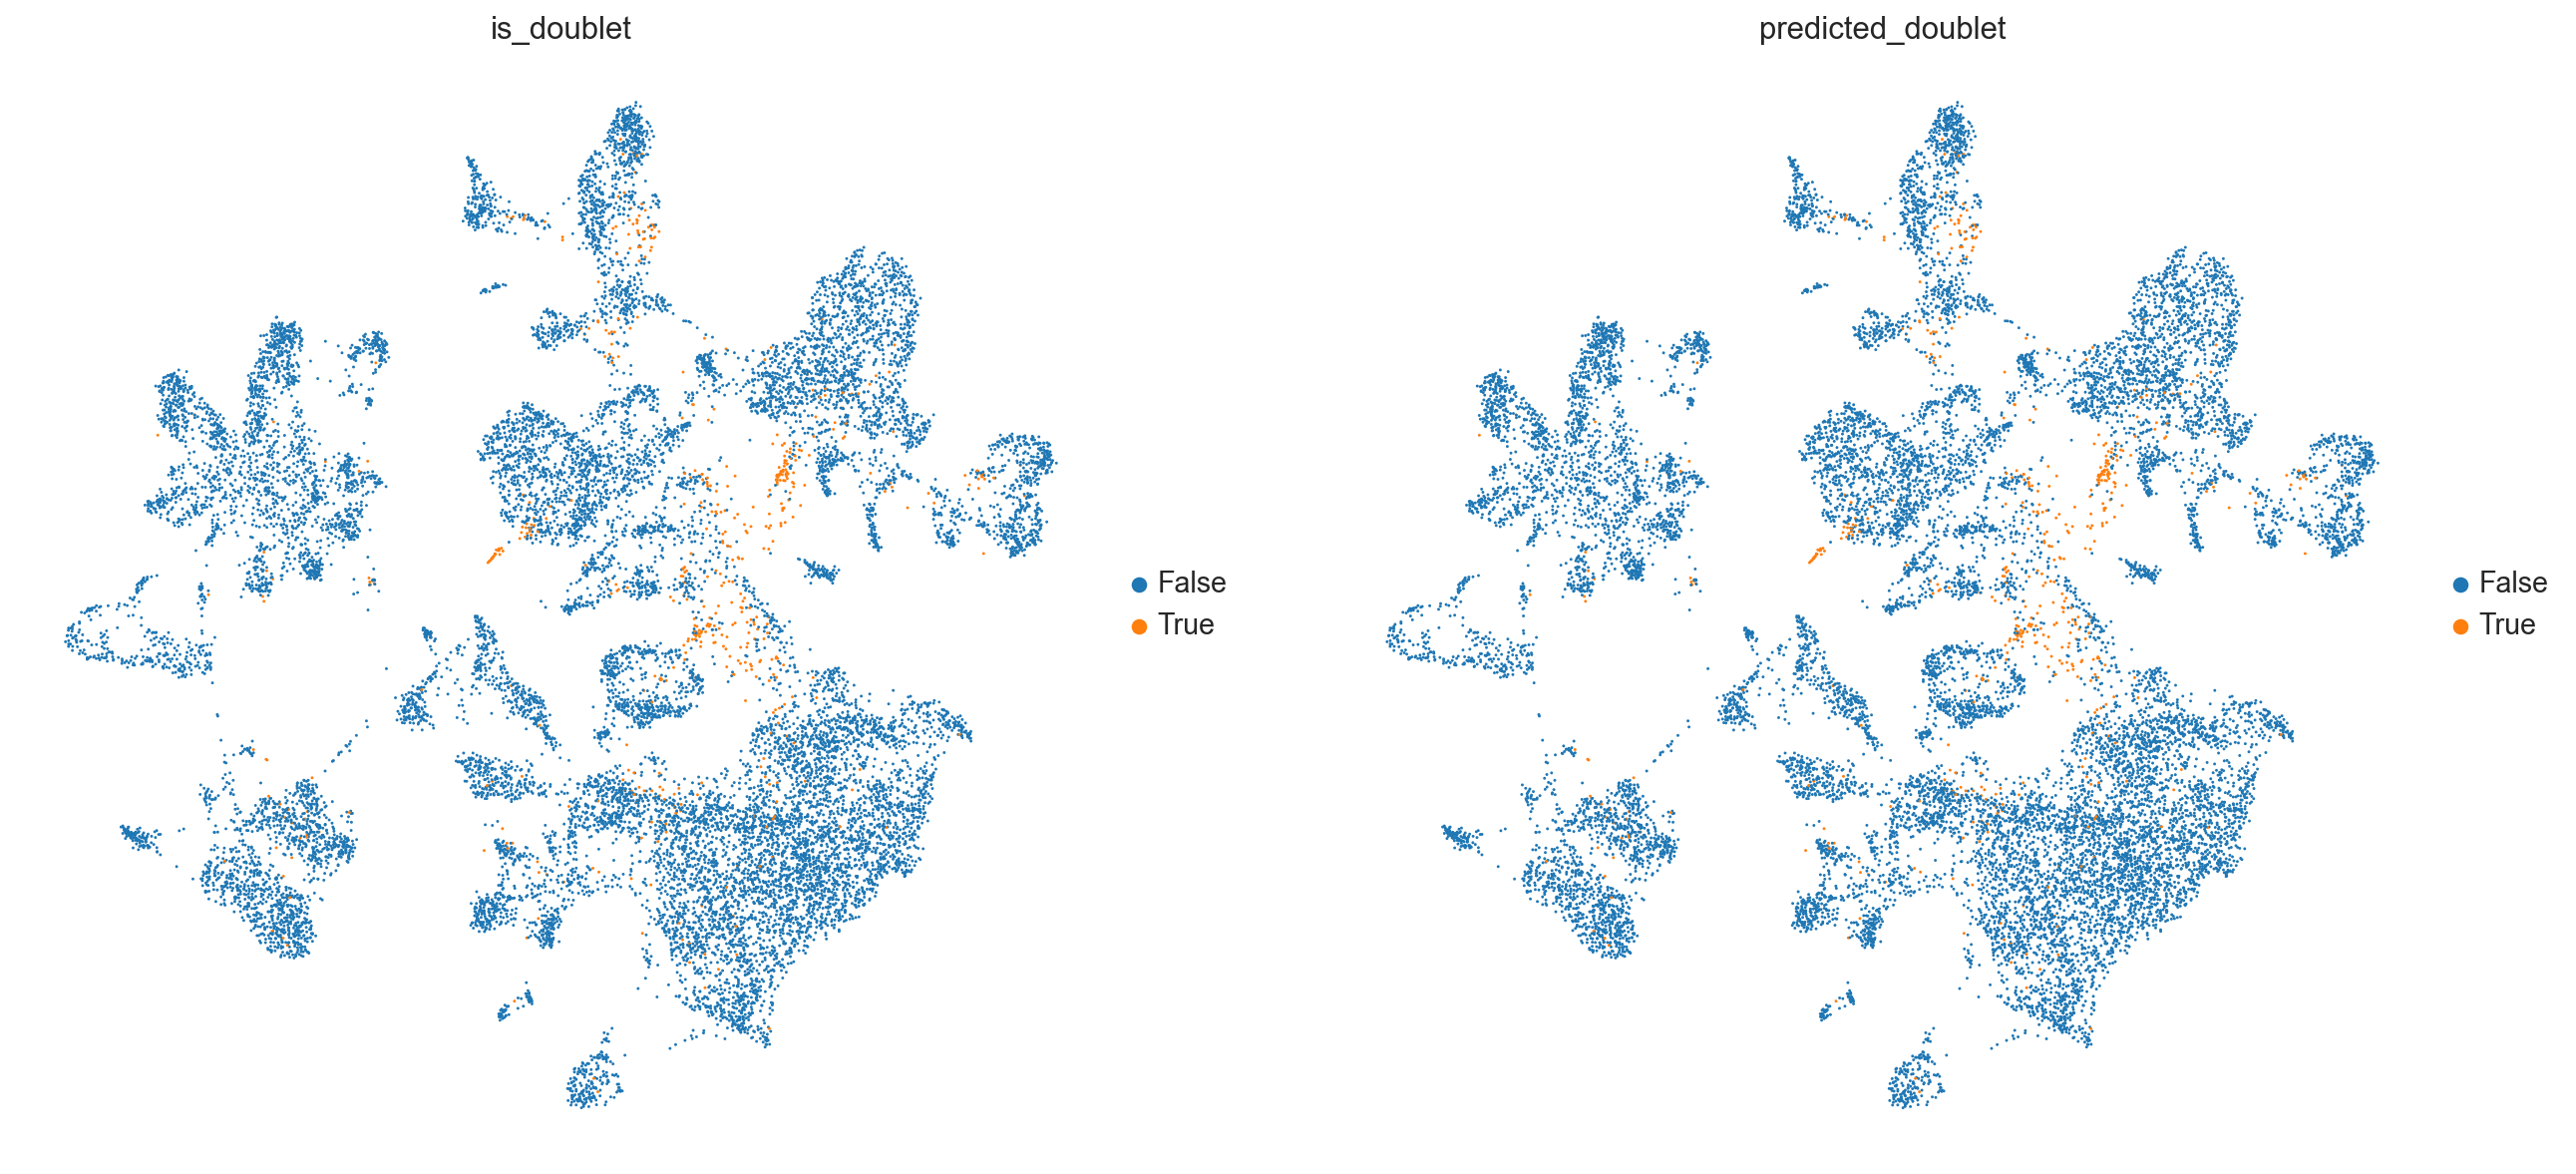

In [8]:
sc.pl.umap(adata=adata, color=["is_doublet", "predicted_doublet"])

In [9]:
adata.write("data/adata_processed_2_lea.h5ad")

### Quality Control Paper

- Our analysis includes the 18,435 cells and 18,025 genes passing quality-control thresholds
- average of 1,975 unique genes and 7,051 unique transcripts detected per cell.
